# [MICRO-452:] Project Report - Groupe 28
**Authors:** Celest Angela Tjong, Adrien Louis Baptiste Dupont, Luca Sidoti Pinto, Didier Henri Neuenschwander
**Supervisors:** Prof. Francesco Mondada
Date: 17 Novembre 2023

[MICRO-452]: **to be changed**


<span style="color:red; font-size:40px;">use as few personal pronouns as possible (we, our, etc.
)

# Table of Contents
* [1. Introduction](#introduction)
* [2. Vision](#vision)
    * [2.1. Subsection 1](#vision-subsection-1)
    * [2.2. Subsection 2](#vision-subsection-2)
* [3. Global Navigation](#global-navigation)
* [4. Filtering](#filtering)
* [5. Local Navigation](#local-navigation)
* [6. Conclusion](#conclusion)
lusion)
clusion)
usion)


## 1 Introduction
<a id="introduction"></a>

In [296]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from PIL import Image
import math
import time
from ipywidgets import interactive
%matplotlib inline

## 2 Vision
<a id="vision"></a>
https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html

### Vision Subsection 1
<a id="Vision-subsection-1"></a>
**Ask to TA if we have to describe every function used in the notebook?**
1. **Color Space Conversion**:
   -In order to have consistent result for the detection, it is standard to convert     The function begins by converting the input image from the BGR color space (standard in OpenCV) to the HSV color space using `cv2.cvtColor`. HSV (Hue, Saturation, Value) is often more effective for color filtering. Indeed it is particulary usefull for image processing  because it separates color information (hue) from intensity or lighting (value). Thus it allows the recognition to be less dependant of the lighting condition, as it is possible to modify theses parameter. In order to fix the variables of the color used, it is a good practise to calibrate the calibrate the HSV in case of light changes. It has been done with the function...




1. **Color Space Conversion**:
   -In order to have consistent result for the detection, it is standard to convert     The function begins by converting the input image from the BGR color space (standard in OpenCV) to the HSV color space using `cv2.cvtColor`. HSV (Hue, Saturation, Value) is often more effective for color filtering. Indeed it is particulary usefull for image processing  because it separates color information (hue) from intensity or lighting (value). It allows the recognition to be less dependant of the lighting condition, as it is possible to modify theses parameter. 



In [297]:
# Define color thresholds in HSV
# Note: these thresholds may need to be adjusted for your specific image conditions
lower_red_bound = np.array([120, 100, 70])
upper_red_bound = np.array([255, 255, 255])
lower_green_bound = np.array([60, 50, 100])
upper_green_bound = np.array([100, 255, 255])
lower_yellow_bound = np.array([0, 30, 120])
upper_yellow_bound = np.array([40, 105, 255])
lower_black_bound = np.array([0, 0, 0])
upper_black_bound = np.array([255, 255, 130])

The first think to do is to preprocess the image for the colour object needed to be located. It is done by first creating a mask. The mask is created by specifying a range of colors (in HSV color space). Pixels within this color range are marked as 1 (or true), while all other pixels are marked as 0 (or false). it is created using `cv2.inRange` which filters out all colors except those within the specified `lower_color_bound` and `upper_color_bound`. This step isolated the specified color. 
Then the function `cv2.bitwise_and`, extract the area corresponding with the range of colour of the image given as input. It is done by comaparing each pixel of the image with the mask (same size of the image, comaparing with a logical &). 
Finally The color-filtered image is converted to grayscale using `cv2.cvtColor` because the subsequent edge detection step (Canny) requires a single-channel image.


In order to detect the different coloured form, it is common to beginby using a canny filter

### Function: `detect_color_circle`

#### Purpose:
The `detect_color_circle` function is designed to detect circles of a specific color in an image. It employs color filtering, Canny edge detection, and the Hough Circle Transform to achieve this.

#### Process:



2. **Color Masking**:
   - A mask is created using `cv2.inRange` which filters out all colors except those within the specified `lower_color_bound` and `upper_color_bound`. This step isolates the regions of the specified color.

3. **Mask Application**:
   - The mask is then applied to the original image using `cv2.bitwise_and`. This step ensures that only the parts of the image with the desired color are retained for further processing.

4. **Grayscale Conversion**:
   - The color-filtered image is converted to grayscale using `cv2.cvtColor` because the subsequent edge detection step (Canny) requires a single-channel image.

5. **Canny Edge Detection**:
   - `cv2.Canny` is applied to detect edges in the image. It works by identifying areas in the image where sharp changes in intensity occur. The function takes two threshold values (here, 100 and 200) that determine the sensitivity of the edge detection. Edges that are found are used as input for the circle detection.

6. **Hough Circle Transform**:
   - `cv2.HoughCircles` is used to detect circles in the image. It operates on the principle of the Hough Transform, which is a feature extraction technique used in image analysis. The function detects circles by finding sets of edge points that form a circular shape.
   - Parameters like `param1` (higher threshold of the two passed to the Canny edge detector), `param2` (threshold for center detection in the Hough Transform), `minRadius`, and `maxRadius` control the sensitivity and size of the circles to be detected.

7. **Output**:
   - If circles are detected, the function returns a list of tuples, each containing the `(x, y)` coordinates of the center of a circle and its radius. If no circles are found, it returns an empty list.


In [298]:
# Import tdmclient Notebook environment:
#import tdmclient.notebook
#await tdmclient.notebook.start()
# forward
#motor_left_target= 100
#motor_right_target= 100

Function that record a video and save it on the folder of the project

In [299]:
"""
video_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)

video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
# Obtenir les dimensions de la frame
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Définir le codec et créer un objet VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (frame_width, frame_height))

# Enregistrer la vidéo
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if ret:
        # Écrire la frame dans le fichier
        out.write(frame)

        # Afficher la frame (si vous voulez voir le flux en temps réel)
        cv2.imshow('Frame', frame)

        # Quitter avec la touche 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Libérer les ressources
video_capture.release()
out.release()
cv2.destroyAllWindows()
"""


"\nvideo_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)\n\nvideo_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)\nvideo_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)\n# Obtenir les dimensions de la frame\nframe_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))\nframe_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))\n\n# Définir le codec et créer un objet VideoWriter\nfourcc = cv2.VideoWriter_fourcc(*'XVID')\nout = cv2.VideoWriter('output.avi', fourcc, 20.0, (frame_width, frame_height))\n\n# Enregistrer la vidéo\nwhile video_capture.isOpened():\n    ret, frame = video_capture.read()\n    if ret:\n        # Écrire la frame dans le fichier\n        out.write(frame)\n\n        # Afficher la frame (si vous voulez voir le flux en temps réel)\n        cv2.imshow('Frame', frame)\n\n        # Quitter avec la touche 'q'\n        if cv2.waitKey(1) & 0xFF == ord('q'):\n            break\n    else:\n        break\n\n# Libérer les ressources\nvideo_capture.release()\nout.release()\ncv2.dest

In [300]:


# Define a function to detect circles of a specific color
def detect_color_circle(image, lower_color_bound, upper_color_bound):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for the specified color
    mask = cv2.inRange(hsv, lower_color_bound, upper_color_bound)

    # Apply the mask to the original image
    color_only = cv2.bitwise_and(image, image, mask=mask)

    # Convert to grayscale for circle detection
    gray = cv2.cvtColor(color_only, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection to help with circle detection
    edges = cv2.Canny(gray, 100, 200)

    # Use Hough Transform to detect circles
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=20, param2=15, minRadius=10, maxRadius=50)
    
    # If circles are detected, return the list of circles with x, y coordinates and radius
    if circles is not None:
        # Convert the (1, N, 3) array to (N, 3)
        circles = np.uint16(np.around(circles[0, :]))          
        return [(circle[0], circle[1], circle[2]) for circle in circles]
    else:
        return []
    
            




In [301]:

def create_obstacle_mask(image, contours, kernel_size):
    """
    Create a mask with zeros in the areas inside the dilated contours.

    :param image: Input image.
    :param contours: Contours to dilate and fill in the mask.
    :param kernel_size: Size of the kernel used for dilation.
    :return: Mask with zeros inside the dilated contours and ones elsewhere.
    """
    # Create an empty mask of the same size as the image
    h, w = image.shape[:2]
    mask = np.ones((h, w), dtype=np.uint8)

    # Perform dilation to increase the size of the black regions
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    for contour in contours:
        # Create an individual mask for each contour
        contour_mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(contour_mask, [contour], 255)
        contour_mask = cv2.dilate(contour_mask, kernel, iterations=1)
        
        # Combine the individual mask with the global mask
        mask = cv2.bitwise_and(mask, cv2.bitwise_not(contour_mask))

        #also add the contours
        # Let's create a border around the image
        border_size = 50
        border_color = [0, 0, 0]  # Black border
        # Use cv2.copyMakeBorder to add a border around the image
        mask_with_border = cv2.copyMakeBorder(mask, border_size, border_size, border_size, border_size,
                                           cv2.BORDER_CONSTANT, value=border_color)
    
    return mask_with_border


# Now you have a mask with zeros in the obstacle areas and ones elsewhere
# You can return this mask from your function or process it further as needed


In [302]:
"""
def scale_contour(contour, scale):
    M = cv2.moments(contour)
    if M['m00'] == 0:
        return contour
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    scaled_contour = np.zeros_like(contour)
    for i, point in enumerate(contour):
        x, y = point[0]
        dx = x - cx
        dy = y - cy
        scaled_contour[i] = [[int(cx + dx * scale), int(cy + dy * scale)]]
    return scaled_contour

def detect_obstacle_contours(image, area_threshold, scale_factor):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_black = cv2.inRange(hsv, lower_black_bound, upper_black_bound)
    contours, _ = cv2.findContours(mask_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]

    scaled_contours = [scale_contour(cnt, scale_factor) for cnt in filtered_contours]
    
    contour_image = image.copy()
    cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)
    cv2.drawContours(contour_image, scaled_contours, -1, (0, 0, 255), 2)
    return contour_image, filtered_contours, scaled_contours
"""

"\ndef scale_contour(contour, scale):\n    M = cv2.moments(contour)\n    if M['m00'] == 0:\n        return contour\n    cx = int(M['m10']/M['m00'])\n    cy = int(M['m01']/M['m00'])\n    scaled_contour = np.zeros_like(contour)\n    for i, point in enumerate(contour):\n        x, y = point[0]\n        dx = x - cx\n        dy = y - cy\n        scaled_contour[i] = [[int(cx + dx * scale), int(cy + dy * scale)]]\n    return scaled_contour\n\ndef detect_obstacle_contours(image, area_threshold, scale_factor):\n    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)\n    mask_black = cv2.inRange(hsv, lower_black_bound, upper_black_bound)\n    contours, _ = cv2.findContours(mask_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)\n    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]\n\n    scaled_contours = [scale_contour(cnt, scale_factor) for cnt in filtered_contours]\n    \n    contour_image = image.copy()\n    cv2.drawContours(contour_image, filtered_contours, -1, (

In [303]:


def detect_obstacle_contours(image, area_threshold, kernel_size):
    """
    Detects and dilates obstacle contours in the given image.
    :param image: Input image.
    :param area_threshold: Area threshold for filtering contours.
    :param kernel_size: Size of the kernel used for dilation.
    :return: Image with obstacle contours drawn.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask_black = cv2.inRange(hsv, lower_black_bound, upper_black_bound)
    contours, _ = cv2.findContours(mask_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask_dilated = cv2.dilate(mask_black, kernel, iterations=1)
    dilated_contours, _ = cv2.findContours(mask_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    filtered_dilated_contours = [cnt for cnt in dilated_contours if cv2.contourArea(cnt) > area_threshold+10000]
    contour_image = image.copy()
    cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)
    cv2.drawContours(contour_image, filtered_dilated_contours, -1, (0, 0, 255), 2)
    return contour_image, filtered_contours, filtered_dilated_contours


In [304]:
def create_obstacle_matrix(image, dilated_contours):
    height, width = image.shape[:2]
    obstacle_matrix = np.ones((height, width), dtype=np.uint8)

    for contour in dilated_contours:
        # Remplir chaque contour dilaté avec 0 (obstacle)
        cv2.fillPoly(obstacle_matrix, [contour], 0)

    return obstacle_matrix


In each frame, there are multiple elements that need to be displayed. The first category includes static elements such as the contours of obstacles and the goal point. Since these do not change over time, it is computationally more efficient to identify and locate them in the first frame, and then display them consistently in subsequent frames.

On the other hand, elements related to the robot's localization must be determined in each frame. To gather information about its orientation and location, three circles are placed on the top of the robot. A green circle is located at the middle back, and two red circles are positioned on each side, with their centers aligned with the robot's ceeris. This arrangement facilitates the extraction of necessary information. By connecting the centers of the two red circles and creating a midpoint, a vector c thenan be formed by connecting this midpoint to the center of the green circ.It might also be feasible to use only two markers (circles), one at the back and one at the front, distinguished by their color. However, the marker at the front would hide the press button.le

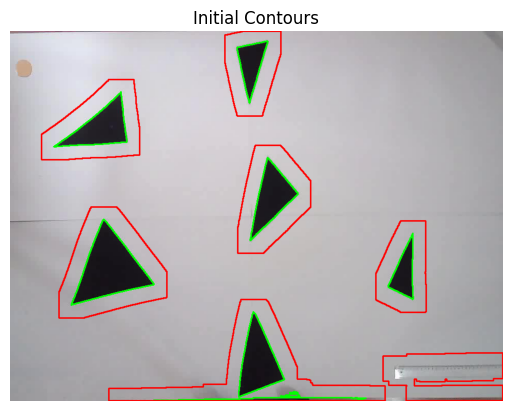

KeyboardInterrupt: 

In [315]:

# Chemin du fichier vidéo enregistré
video_path = 'output.avi'

# Ouvrir le fichier vidéo
video_capture = cv2.VideoCapture(video_path)

# Assurez-vous que le fichier vidéo s'ouvre correctement
if not video_capture.isOpened():
    print("Erreur : Impossible d'ouvrir le fichier vidéo.")
    exit()
#video_capture = cv2.VideoCapture(0, cv2.CAP_DSHOW)

video_capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1080)
video_capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
window_name = 'Robot Detection'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

# Redimensionner la fenêtre (largeur, hauteur)
cv2.resizeWindow(window_name, 540, 360)  # Réduire de moitié par exemple

# Initial detection of obstacles
ret, initial_frame = video_capture.read()
if ret:
     contour_image = detect_obstacle_contours(initial_frame, 1000, 50)
     global_obstacle = create_obstacle_matrix(initial_frame, contour_image[2])
     plt.imshow(cv2.cvtColor(contour_image[0], cv2.COLOR_BGR2RGB))
     plt.title('Initial Contours')
     plt.axis('off')
     plt.show()
     yellow_circles = detect_color_circle(initial_frame, lower_yellow_bound, upper_yellow_bound)
     if yellow_circles:
    # Stocker les coordonnées du premier cercle jaune détecté
        yellow_circle_coords = yellow_circles[0]

# Robot update frequency (10 Hz)
update_rate = 0.1  # 10 times per second

try:
    while True:
        start_time = time.time()
        
        # Capture frame-by-frame
        ret, frame = video_capture.read()
        if not ret:
            break

        # Mettre à jour les contours d'obstacle pour la frame actuelle
 
        # Detect red and green circles
        red_circles = detect_color_circle(frame, lower_red_bound, upper_red_bound)
        green_circles = detect_color_circle(frame, lower_green_bound, upper_green_bound)


        
        if yellow_circles:
            x, y, r = yellow_circles[0] #coordinate of the goal*********************************************************
            cv2.circle(frame, (x, y), r, (0, 255, 255), 3) # Dessiner les cercles jaunes

            
        if red_circles and green_circles:
                    if len(red_circles) >= 2:
                        # Calculate the midpoint between the centers of the red circles
                        midpoint = ((red_circles[0][0] + red_circles[1][0]) // 2,
                        (red_circles[0][1] + red_circles[1][1]) // 2)
                        # Calculer le vecteur directionnel
                        direction = np.array([midpoint[0] - green_circles[0][0], midpoint[1] - green_circles[0][1]])
                    
                        # Normaliser et allonger le vecteur
                        length = 100  # Longueur supplémentaire
                        direction = direction / np.linalg.norm(direction) * length
                    
                        # Calculer le nouveau point d'arrivée
                        new_endpoint = (int(green_circles[0][0] + direction[0]), int(green_circles[0][1] + direction[1]))
                    
                        # Dessiner la flèche allongée
                        cv2.arrowedLine(frame, green_circles[0][:2], new_endpoint, (0, 0, 0), 3)

                        # Calculate the angle of orientation with respect to the x-axis
                        dx = green_circles[0][0] - midpoint[0]
                        dy = green_circles[0][1] - midpoint[1]
                        angle = math.atan2(dy, dx)
                        angle_degrees = math.degrees(angle)
                        if(angle_degrees >= 0):
                            angle_degrees =180 - angle_degrees
                        elif (angle_degrees < 0):
                            angle_degrees = 180 + angle_degrees
                        robot_vector = (midpoint[0], midpoint[1], angle_degrees) #information of the robot
                        # Optionally, display the angle
                        cv2.putText(frame, f'Angle: {angle_degrees:.2f} degrees', (10, 30), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                     
                        cv2.putText(frame, f'Midpoint: ({midpoint[0]}, {midpoint[1]})', (10, 700),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
        cv2.drawContours(frame, contour_image[1], -1, (0, 255, 0), 2)
        cv2.drawContours(frame, contour_image[2], -1, (0, 0, 255), 2)
        # Dimensions de la frame

        height, width = frame.shape[:2]

        # Coordonnées du point de départ du repère (bas droit de l'image)
        origin_x, origin_y = width - 150, height - 70  # Ajustement pour une longueur de 100
        # Dessiner l'axe X
        cv2.line(frame, (origin_x, origin_y), (origin_x + 100, origin_y), (0, 0, 255), 2)
        # Dessiner l'axe Y 
        cv2.line(frame, (origin_x, origin_y), (origin_x, origin_y - 100), (0, 255, 0), 2)
        # Marquer la longueur sur l'axe X
        cv2.putText(frame, "100", (origin_x + 100, origin_y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 2)
        # Marquer la longueur sur l'axe Y
        cv2.putText(frame, "100", (origin_x - 30, origin_y - 100), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 255), 2)
        cv2.putText(frame, f'({origin_x}, {origin_y})', (origin_x-200, origin_y-10),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2) #environ 14cm pour 100pixcel
        # ... (le reste de votre code pour afficher la frame)
        # Display the resulting frame
        cv2.imshow('Robot Detection', frame)

        # Pause to maintain the update frequency
        time_to_wait = max(int((start_time + update_rate - time.time()) * 1000), 1)
        if cv2.waitKey(time_to_wait) & 0xFF == ord('q'):
            break
finally:
    # Release the capture when everything is finished
    video_capture.release()
    cv2.destroyAllWindows()


[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

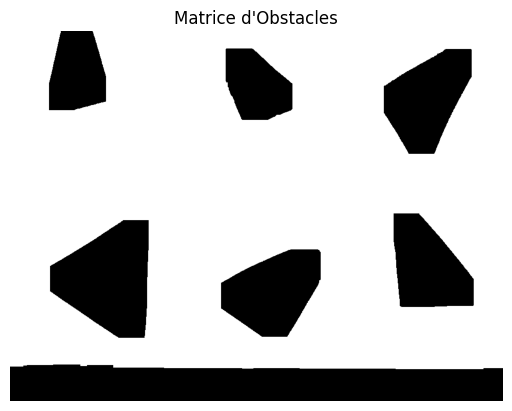

In [211]:
np.set_printoptions(threshold=np.inf)

# Afficher la matrice global_obstacle
print(global_obstacle)
plt.imshow(global_obstacle, cmap='gray')
plt.title('Matrice d\'Obstacles')
plt.axis('off')
plt.show()
x, y, r = yellow_circles[0] #coordinate of the goal*********************************************************


"Initially, for the setup, it's advantageous to position the camera above the play area. This placement minimizes the need to account for perspective distortions. To accurately determine the robot's position and orientation, at least two distinct markers should be placed on the robot. These markers enable precise tracking and analysis of the robot's movements.

In [ ]:


# Detect red and green circles
red_circles = detect_color_circle(image, lower_red_bound, upper_red_bound)
green_circles = detect_color_circle(image, lower_green_bound, upper_green_bound)
yellow_circles = detect_color_circle(image, lower_yellow_bound, upper_yellow_bound)

red_circles, green_circles, yellow_circles

In [ ]:


# Assuming red_circles and green_circles contain the detected circles for each color
# For demonstration, let's create dummy circle data
# red_circles = [(x1, y1, r1), (x2, y2, r2)]
# green_circles = [(x3, y3, r3)]

# TODO: Replace the dummy values with your actual circle centers and radii
#red_circles = [(50, 50, 30), (150, 50, 30)]  # Dummy values
#green_circles = [(100, 150, 30)]  # Dummy values

# Calculate the midpoint between the centers of the red circles
midpoint = ((red_circles[0][0] + red_circles[1][0]) // 2,
            (red_circles[0][1] + red_circles[1][1]) // 2)

# Draw a line (and arrow) from the green circle's center to the midpoint
cv2.arrowedLine(image,  green_circles[0][:2],midpoint, (0, 255, 0), 20)

# Calculate the angle of orientation with respect to the x-axis
dx = green_circles[0][0] - midpoint[0]
dy = green_circles[0][1] - midpoint[1]
angle = math.atan2(dy, dx)
angle_degrees = math.degrees(angle)

# Display the image with the drawn arrow
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Angle of orientation: {angle_degrees:.2f} degrees')
plt.axis('off')
plt.show()

# Return the midpoint and the angle
midpoint, angle_degrees


For the obstacle detection: we used black shapes that we randomly distribute around the board. It is 

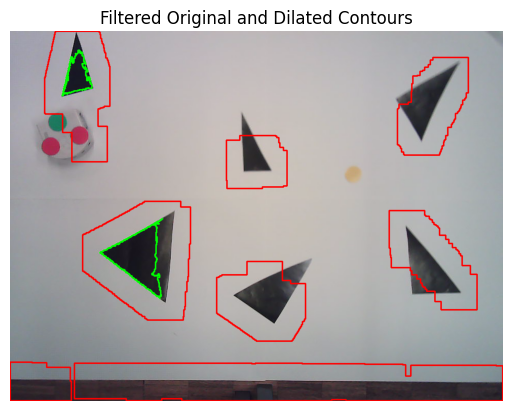

In [271]:

#image_path = 'WIN_20231124_15_09_52_Pro.jpg'
image = initial_frame #cv2.imread(image_path)
image = frame.copy()  # Créer une copie de l'image
# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for the black color
lower_black = np.array([0, 0, 0])
upper_black = np.array([180, 150, 40])

# Create a black color mask
mask_black = cv2.inRange(hsv, lower_black, upper_black)

# Find contours in the mask
contours, _ = cv2.findContours(mask_black, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Set a realistic threshold for the area of the contours
area_threshold = 2000  # Adjust this threshold according to your needs

# Filter the original contours that are larger than the threshold
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > area_threshold]

# Perform dilation to increase the size of the black regions
kernel_size = 70  # Kernel size can be adjusted to control the amount of dilation
kernel = np.ones((kernel_size, kernel_size), np.uint8)
mask_dilated = cv2.dilate(mask_black, kernel, iterations=1)

# Find contours in the dilated mask
dilated_contours, _ = cv2.findContours(mask_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter the dilated contours that are larger than the threshold
filtered_dilated_contours = [cnt for cnt in dilated_contours if cv2.contourArea(cnt) > area_threshold]

# Draw the filtered original contours in green
for contour in filtered_contours:
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)

# Draw the filtered dilated contours in red
for contour in filtered_dilated_contours:
    cv2.drawContours(image, [contour], -1, (0, 0, 255), 2)

# Display the image with the drawn contours
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Filtered Original and Dilated Contours')
plt.axis('off')  # Hide the axis
plt.show()


# Tool functions that help with parameter tuning:
<a id="Vision-subsection-2"></a>


In [142]:
def plot_detected_circles(image, circles, circle_color):
    """
    Draws the detected circles on the image and plots it.

    :param image: The original image.
    :param circles: A list of circles with their coordinates and radius.
    :param circle_color: The color to use for drawing the circles.
    :return: None
    """
    if circles is not None and len(circles) > 0:
        for circle in circles:
            center = (circle[0], circle[1])  # Circle center
            radius = circle[2]  # Circle radius
            # Draw the circle's perimeter
            cv2.circle(image, center, radius, circle_color, 2)
            # Draw the circle's center
            cv2.circle(image, center, 2, circle_color, 3)

    # Plot the image with detected circles
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axis
    plt.show()


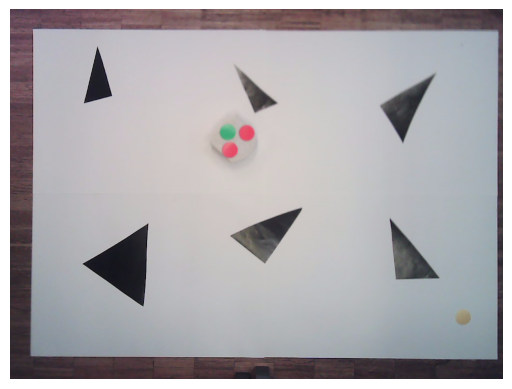

In [143]:


# Vérification si la frame a été capturée avec succès
if ret:
    # Conversion de l'image en RGB pour l'affichage avec Matplotlib
    frame_rgb = cv2.cvtColor(initial_frame, cv2.COLOR_BGR2RGB)
    
    # Affichage de l'image
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()
else:
    print("Erreur lors de la capture de l'image.")


In [144]:
# Obtenir les dimensions de l'image
h, w = frame_rgb.shape[:2]

# Calculer le nombre total de pixels
total_pixels = h * w

print(f"The image is of dimension {w}x{h} (width x hight)")
print(f"The total number of pixels is : {total_pixels}")

height, width = global_obstacle.shape

print("Hauteur de la matrice:", height)
print("Largeur de la matrice:", width)


The image is of dimension 960x720 (width x hight)
The total number of pixels is : 691200
Hauteur de la matrice: 720
Largeur de la matrice: 960


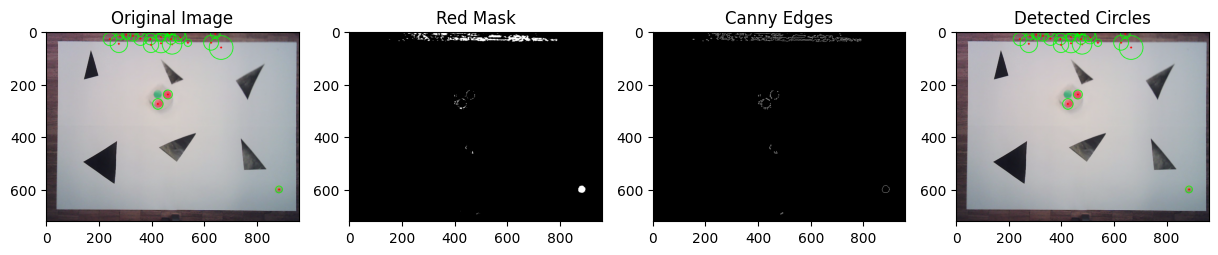

In [145]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
image = initial_frame #cv2.imread('WIN_20231124_15_09_52_Pro.jpg')
image = image.copy()
# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the lower and upper bounds for the red color
# Note: Adjust these values according to your color calibration


# Create a red color mask
mask_red = cv2.inRange(hsv, lower_yellow_bound, upper_yellow_bound)

# Apply the mask to the image
red_only = cv2.bitwise_and(image, image, mask=mask_red)

# Convert the result to grayscale
gray = cv2.cvtColor(red_only, cv2.COLOR_BGR2GRAY)


# Apply Canny edge detection to help with circle detection
edges = cv2.Canny(gray, 100, 200)

# Detect circles using the Hough Transform
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20,
                           param1=20, param2=15, minRadius=10, maxRadius=50)

# If circles are detected, draw them
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)

# Plotting the different stages
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(mask_red, cmap='gray')
plt.title('Red Mask')

plt.subplot(1, 4, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')

plt.show()

In [146]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interactive

def interactive_mask(lower_h, lower_s, lower_v, upper_h, upper_s, upper_v):
    
    lower_color_bound = np.array([lower_h, lower_s, lower_v])
    upper_color_bound = np.array([upper_h, upper_s, upper_v])

    # Ensure initial_frame is defined here, or pass it as an argument to this function
    image = initial_frame.copy()
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    mask = cv2.inRange(hsv, lower_color_bound, upper_color_bound)
    plt.imshow(mask, cmap='gray')
    plt.show()

# Define initial_frame here or load it before this point
# initial_frame = cv2.imread('your_image.jpg')

# Setup interactive widgets
interactive(interactive_mask, 
            lower_h=(0,255), lower_s=(0,255), lower_v=(0,255),
            upper_h=(0,255), upper_s=(0,255), upper_v=(0,255))
# Assuming 'hsv' is your converted HSV image
#lower_red_bound = np.array([120, 70, 120])
#upper_red_bound = np.array([255, 255, 255])
#lower_green_bound = np.array([60, 120, 100])
#upper_green_bound = np.array([100, 255, 255])
#lower_black = np.array([0, 0, 0])
#upper_black = np.array([255, 255, 130])
#lower_yellow_bound = np.array([0, 60, 140])
#upper_yellow_bound = np.array([40, 105, 255])


interactive(children=(IntSlider(value=127, description='lower_h', max=255), IntSlider(value=127, description='…

In [ ]:
image = frame #cv2.imread('WIN_20231124_15_09_52_Pro.jpg')
red_circles = detect_color_circle(image, lower_red_bound, upper_red_bound)
green_circles = detect_color_circle(image, lower_green_bound, upper_green_bound)
yellow_circles = detect_color_circle(image, lower_yellow_bound, upper_yellow_bound)

red_circles, green_circles, yellow_circles

# Assuming red_circles and green_circles contain the detected circles for each color
image_copy = image.copy()  # Make a copy to draw on
plot_detected_circles(image_copy, red_circles, (200, 0, 255))  # Red color for red circles
plot_detected_circles(image_copy, green_circles, (0, 255, 0))  # Green color for green circles
plot_detected_circles(image_copy, yellow_circles,(255,255,153))  # yellow color for yellow circles


## 3 Global Navigation
<a id="global-navigation"></a>

In [257]:
global_obstacle = np.logical_not( global_obstacle )
max_val_x_init = global_obstacle.shape[0]
max_val_y_init = global_obstacle.shape[1]

reduction_coeff = 20 # tune for speed
max_val_x = int(max_val_x_init / reduction_coeff)
max_val_y = int(max_val_y_init / reduction_coeff)

occupancy_grid = np.zeros((max_val_x, max_val_y), dtype=int)
for i in range (max_val_x):
    for j in range (max_val_y):
        sum_pixels = 0
        for k in range (reduction_coeff): # dans le doute on augmente la distance de sécurité avec obstacle
            sum_pixels = sum_pixels + global_obstacle[int(i * reduction_coeff - reduction_coeff/2 + k)][int(j * reduction_coeff - reduction_coeff/2 + k)]
        if sum_pixels == 0:
            occupancy_grid[i][j] = 0
        else:
            occupancy_grid[i][j] = 1

In [258]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    #ax.set_ylim([-1,max_val_x])
    ax.set_ylim([max_val_x,-1])
    ax.set_xlim([-1,max_val_y])
    ax.grid(True)
    
    return fig, ax

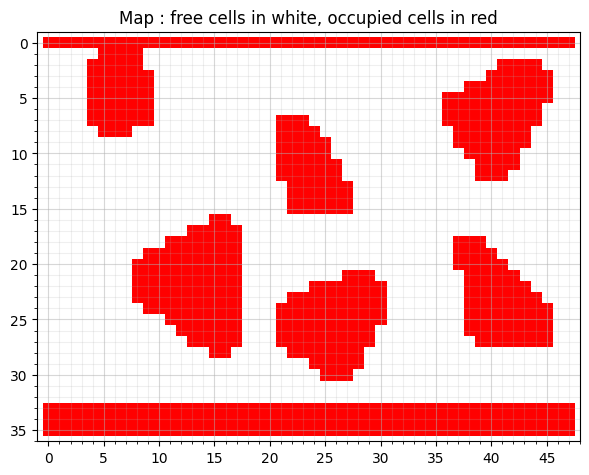

In [264]:
# Printing the grid

fig, ax = create_empty_plot(max_val_y)

cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

occupancy_grid = np.logical_not(occupancy_grid)

# Displaying the map
ax.imshow(occupancy_grid, cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");

## A* implementation

In [265]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [266]:

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type="4N", max_val_x=max_val_x, max_val_y=max_val_y):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val_y, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


[[100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 400 400
  400 400 420 440 460 480 500 520 540 540 560 560 580 580 600 600 600 620]
 [200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540
  560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900]]


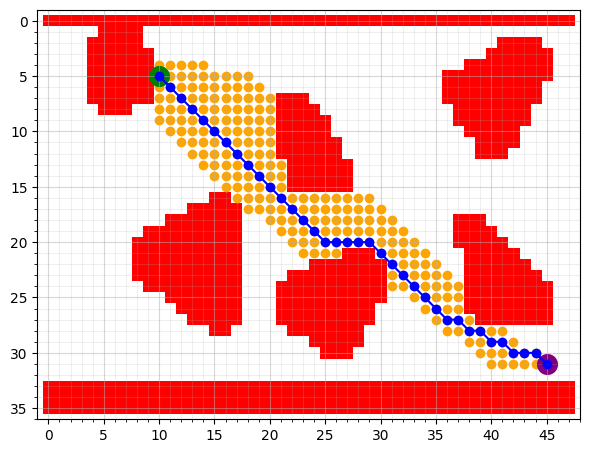

In [267]:
# Define the start and end goal
start = (int(robot_vector[0]/reduction_coeff),int(robot_vector[1]/reduction_coeff))
goal = (int(630 /reduction_coeff),int(900 /reduction_coeff))



# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
w,z = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
pos = np.empty(w.shape + (2,))
pos[:, :, 0] = w; pos[:, :, 1] = z
pos = np.reshape(pos, (w.shape[0]*w.shape[1], 2))
coords = list([(int(w[0]), int(w[1])) for w in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

path_final = path * reduction_coeff

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val_y)
ax_astar.imshow(occupancy_grid, cmap=cmap)
print(path_final)
# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[1], visitedNodes[0], marker="o", color = 'orange');
ax_astar.plot(path[1], path[0], marker="o", color = 'blue');
ax_astar.scatter(start[1], start[0], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200);

In [268]:
start,goal

((5, 10), (31, 45))

- blanc : libre
- rouge : obstacle
- orange : case explorée
- bleu : chemin le plus court
- vert : départ
- violet : arrivée

Maintenant que nous avons calculé le chemin le plus court, nous appelons des fonctions pour diriger le robot dans la bonne direction. Les données qui sortent de ce fichier sont dans la matrice path_final qui regroupe les coordonées des étapes recalculées à la bonne échelle.

In [284]:
gamma = 0 # angle entre orientation actuelle et orientation pour le point suivant
current_node = 1 # indice de l'étape suivante
dist_to_node = 0 # distance en pixels séparant le robot de l'étape suivante  
norm_vector_node = np.array([0,0]) # vecteur normalisé reliant la position à la prochaine étape

if(robot_vector[2] >= 0):
    orientation = math.radians(180 - robot_vector[2])
elif (robot_vector[2] < 0):
    orientation = math.radians( -(180 + robot_vector[2]))


ANGLE_THRESHOLD = 0.1 # valeur à partir de laquelle le robot arrête de tourner et commence à avancer vers la prochaine étape
DISTANCE_TO_NODE_THRESHOLD = 5 # valeur à partir de laquelle le robot change d'étape
ROTATION_TIME_THRESHOLD = 400
FORWARD_TIME_THRESHOLD = 100

while True:
    norm_vector_node[0] = path[0][current_node] - position[0]
    norm_vector_node[1] = path[1][current_node] - position[1] # calcul du vecteur normalisé
    norm_vector_node = norm_vector_node / np.linalg.norm(norm_vector_node)
    alpha = np.arctan(norm_vector_node) # calcul de l'angle (A REFAIRE EN FONCTION DE COMMENT ON CALCULE LES ORIENTATIONS)

    gamma = np.arccos(np.dot(position,norm_vector_node))  # Calcul de gamma
    print(path[:][current_node])
    dist_to_node = np.linalg.norm(path[:, current_node] - position) # On calcule la distance 


    if (abs(gamma) > ANGLE_THRESHOLD): # Tourner le robot jusqu'à être en dessous d'une certaine valeur de threshold

        start_time = time.time()
        #
        #
        # fonction qui fait tourner le robot pour être dans la bonne direction
        # turn on the spot
        while ((time.time() - start_time) < abs(gamma)*ROTATION_TIME_THRESHOLD):
            motor_left_target= -100 * math.copysign(1, gamma)
            motor_right_target= 100 * math.copysign(1, gamma)
        #
        #
        end_time = time.time()
        elapsed_time_rot = end_time - start_time
        print(elapsed_time_rot)

    if (dist_to_node > DISTANCE_TO_NODE_THRESHOLD): # Avancer le robot jusqu'à  atteindre la prochaine étape

        start_time = time.time()
        #
        #
        # fonction pour faire avancer le robot à 60
        while ((time.time() - start_time) < abs(gamma)*ROTATION_TIME_THRESHOLD):
            motor_left_target = 200
            motor_left_target = 200
        #
        #
        end_time = time.time()
        elapsed_time_forw = end_time - start_time # return la distance parcourue en multipliant la vitesse par le temps
        

    current_node = current_node + 1


    if current == path.shape[1]:
        break
print("On est arrivé")

NameError: name 'position' is not defined

# Kalman Filterwhile 1:"
 on3",
   "version": "3.11.5"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 5
}

The localization of the Thymio robot is performed using a Kalman filter. This filtering method is well suited to estimating the position and orientation of a mobile robot from noisy or incomplete measurements. The design of the filter in this project is based on using the position ($x, y$) and orientation ($\theta$) provided by the camera as measurements. In addition, the speed of the robot, provided by the wheel speed sensors ($v_r, v_l$), is used as a prediction. In short, the Kalman filter merges a prediction of the system's future state with a measurement of that state to estimate position probabilistically.

## State-space model

### Prediction

To estimate the robot's future position, a state-space model needs to be developed: 

$$\hat{s}_{a\_priori}^{t+1} = A \cdot \hat{s}_{a\_posteriori}^{t} + B \cdot u^{t} + q^t$$

The prediction of the future state is referred to as $\hat{s}_{a\_priori}^{t+1}$, i.e. the a priori estimate at time t+1. Since the state of the system is defined by its position ($x, y$) and orientation ($\theta$), this gives: 

$$\hat{s}_{a\_priori}^{t+1} = \begin{pmatrix}
\hat{x}_{a\_priori}^{t+1} \\\\
\hat{y}_{a\_priori}^{t+1} \\\\
\hat{\theta}_{a\_priori}^{t+1}
\end{pmatrix}$$

The current state corresponds to the term $\hat{s}_{a\_posteriori}^{t}$, which is the a posteriori estimate at time t. In the same way as above, this gives:

$$\hat{s}_{a\_posteriori}^{t} = \begin{pmatrix}
\hat{x}_{a\_posteriori}^{t} \\\\
\hat{y}_{a\_posteriori}^{t} \\\\
\hat{\theta}_{a\_posteriori}^{t}
\end{pmatrix}$$

The system input at time t is represented by the vector $u^{t}$. This is made up of two terms: translational speed ($v$) and rotational speed ($\omega$). 

$$u^t = \begin{pmatrix}
v \\\\
\omega
\end{pmatrix} $$

These are defined on the basis of the speeds measured by the wheel speed sensors, i.e. the right ($v_r$) and left ($v_l$) speeds, and the spacing between the two wheels ($e$).

$$ v = \cfrac{v_r + v_l}{2} \qquad\qquad \omega = \cfrac{v_r-v_l}{e} $$ 

Matrix A characterizes the evolution of the system state, while matrix B describes the impact of the input on the future state. An odometry-based approach allows us to determine these two matrices by considering a very short time interval ($\delta t$). During this time interval, the robot rotates by $\delta \theta = \omega \cdot \delta t$. Knowing this, and referring to the diagram below, the following system of equations can be established: 

$$\begin{equation}
\begin{cases}
\hat{x}_{a\_priori}^{t+1} = \hat{x}_{a\_posteriori}^{t} + v \cdot \cos\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t \\
\hat{y}_{a\_priori}^{t+1} = \hat{y}_{a\_posteriori}^{t} + v \cdot \sin\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t \\
\hat{\theta}_{a\_priori}^{t+1} = \hat{\theta}_{a\_posteriori}^{t} + \omega \cdot \delta t
\end{cases}
\end{equation}$$

![state-space_model](Images/schematics.png)

The matrix form of this system therefore becomes:

$$\begin{equation}
A = \begin{bmatrix} 
1 & 0 & 0\\ 
0 & 1 & 0 \\ 
0 & 0 & 1
\end{bmatrix}
\qquad\qquad
B = \begin{bmatrix} 
\cos\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t & 0\\
\sin\left(\hat{\theta}_{a\_posteriori}^{t} + \delta \theta^t \right) \cdot \delta t & 0 \\
0 & \delta t 
\end{bmatrix}
\end{equation}$$

The final term $q^t$ of this state-space model represents the stochastic perturbation of the state with covariance matrix Q defined as follows:

$$
Q = \begin{bmatrix} 
q_1 & 0 & 0\\ 
0 & q_2 & 0 \\ 
0 & 0 & q_3
\end{bmatrix}
$$

These diagonal coefficients can be evaluated using an approach similar to that used in Exercise 8 of the MICRO-452 course.  

### Measurement

Having explored the prediction phase of the state-space model, attention now turns to the second essential part: updating the measurements. This stage aims to refine the predictions by integrating real information captured by the camera. The formula governing this step is :

$$ m^{t+1} = C \cdot s^{t+1} + r^{t+1}$$ 

Measurements taken at time t+1 are represented here by the term $m_{t+1}$. The data collected by the camera are therefore:

$$m^{t+1} = \begin{pmatrix}
x_{captured}^{t+1} \\\\
y_{captured}^{t+1} \\\\
\theta_{captured}^{t+1}
\end{pmatrix}$$

The robot's position ($x, y$) and orientation ($\theta$) measured by the camera are used directly as system outputs, without any transformation. The matrix C linking the measurements to the state is therefore defined as follows:

$$C = \begin{bmatrix} 
1 & 0 & 0\\ 
0 & 1 & 0 \\ 
0 & 0 & 1
\end{bmatrix}$$

The term $s^{t+1}$ simply represents the state of the system at time t+1:

$$s^{t+1} = \begin{pmatrix}
x^{t+1} \\\\
y^{t+1} \\\\
\theta^{t+1}
\end{pmatrix}$$

Finally, the last term $r^{t+1}$ of this equation represents noise on measurements with a covariance matrix R defined as follows:

$$
R = \begin{bmatrix} 
r_1 & 0 & 0\\ 
0 & r_2 & 0 \\ 
0 & 0 & r_3
\end{bmatrix}
$$

Note: When the camera's view is obstructed, estimation is only possible using the prediction model.

## Initialization

### Imports

In [285]:
import math
import time
import scipy
import asyncio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import randrange
from tdmclient import aw, ClientAsync

### Basic functions

In [286]:
# Thymio connection
async def connect_Thymio():
    """
    Establish a connection with the Thymio if possible
    """
    global node, client
    try:
        client = ClientAsync()
        node = await asyncio.wait_for(client.wait_for_node(), timeout=2.0)
        await node.lock()
        print("Thymio connected")

    except asyncio.TimeoutError:
        print("Thymio not connected: Timeout while waiting for node.")
    except Exception as e:
        print(f"Thymio not connected: {str(e)}")
        
# Thymio disconnection
def disconnect_Thymio():
    """
    Enable to disconnect the Thymio
    """
    aw(node.stop())
    aw(node.unlock())
    print("Thymio disconnected")

# Thymio control motor speeds  
def set_speeds(left_speed, right_speed):
    """
    Enable to set the speed of the Thymio's wheels
    """
    return {
        "motor.left.target": [left_speed],
        "motor.right.target": [right_speed],
    }
    
# Check
await connect_Thymio()
node.send_set_variables(set_speeds(40, 40))
time.sleep(2)
node.send_set_variables(set_speeds(0, 0))
disconnect_Thymio()

Thymio not connected: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée


NameError: name 'node' is not defined

### Global variables

In [287]:
# General variables:
update_time = 0.05               # Time in [s] before the next update
thymio_speed_to_mms = 0.4348     # Ratio to convert Thymio speed into mm/s
acquire_data = True              # Boolean that determines whether the program should collect data or not
samples_acquired = 0             # Number of samples acquired
nb_samples = 10                  # Number of samples to reach
camera_on = False                # Boolean that determines whether the camera has vision or not

#Thymio variables: 
robot_diameter = 94              # Distance between the two wheels
v_r = 0                          # Speed of the right wheel 
v_l = 0                          # Speed of the left wheel
v_r_tot = 0                      # Sum of right speeds over several samples
v_l_tot = 0                      # Sum of left speeds over several samples
v = 0                            # Average translation speed
w = 0                            # Average rotation speed
delta_theta = 0                  # Angle variation
thymio_data = []

#Thymio position and orientation
x0_vision = 10
y0_vision = 10
theta0_vision = np.pi/2
x_vision = 20
y_vision = 20
theta_vision = np.pi

### Filter initialization

In [288]:
def filter_initialization():
    """
    Initialize the various vectors and matrices requiered for filtering
    
    param vision_x_position: robot x position deduced from the camera vision
    param vision_y_position: robot y position deduced from the camera vision
    param vision_theta_orientation: robot theta orientation deduced from the camera vision
    """
    
    global s_prev_est_a_posteriori, P_prev_est_a_posteriori, A, B, u, C, Q, R

    ## Previous State A Posteriori Estimation Vector
    # Vector representing the estimated state of the system at the previous time step
    s_prev_est_a_posteriori = np.array([[x0_vision], 
                                        [y0_vision], 
                                        [theta0_vision]])
    #print("\n".join([f"s_prev_est_a_posteriori = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in s_prev_est_a_posteriori]), "]"]))
    
    ## Previous State A Posteriori Covariance Matrix
    # Matrix representing the estimated precision of the previous estimated state
    P_prev_est_a_posteriori = np.array([[1000, 0, 0], 
                                        [0, 1000, 0], 
                                        [0, 0, 1000]]) 
    #print("\n".join([f"P_prev_est_a_posteriori = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in P_prev_est_a_posteriori]), "]"]))

    ## State Matrix
    # Matrix defining how the system evolves from one time step to the next
    A = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])
    #print("\n".join([f"A = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in A]), "]"]))
    
    ## Input Matrix 
    # Matrix describing the impact of the input on the state
    B = np.array([[1, 0], 
                  [0, 1], 
                  [0, 0]]); 
    #print("\n".join([f"B = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in B]), "]"]))
    
    ## Input Vector
    # Vector representing control inputs applied to the system 
    u = np.array([[0], 
                  [0]])
    #print("\n".join([f"u = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in u]), "]"]))

    ## Output Matrix
    # Matrix linking measurements to state
    C = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 1]])
    #print("\n".join([f"C = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in C]), "]"]))
    
    ## Process Noise Covariance Matrix
    # Covariance matrix representing uncertainty in system dynamics
    Q = np.array([[1, 0, 0], 
                  [0, 1, 0], 
                  [0, 0, 0.1]])
    #print("\n".join([f"Q = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in Q]), "]"]))

    ## Measurement Noise Covariance Matrix
    # Matrix representing uncertainty of camera measurements
    R = np.array([[0.1, 0, 0], 
                  [0, 0.1, 0], 
                  [0, 0, 0.01]])
    #print("\n".join([f"R = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in R]), "]"]))

# Check
#filter_initialization()

## Update

In [289]:
from threading import Timer

# Define a RepeatedTimer class that uses Python's threading module to create 
# a timer that executes a specific function at regular intervals

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

def get_data():
    global v_r, v_l, v_r_tot, v_l_tot, samples_acquired, thymio_data
    if samples_acquired<nb_samples:
        if samples_acquired == 0:
            thymio_data.clear() 
        thymio_data.append({"left_speed":node["motor.left.speed"],
                            "right_speed":node["motor.right.speed"]})
        v_r_tot += node["motor.right.speed"]
        v_l_tot += node["motor.left.speed"]
        samples_acquired += 1
        #print("sample number : ", samples_acquired)
        #print("Right = {}, Left = {}".format(node["motor.right.speed"], node["motor.left.speed"]))
    else:
        v_r = round(v_r_tot/nb_samples)
        v_l = round(v_l_tot/nb_samples)
        
async def get_speeds():
    global samples_acquired, v_r_tot, v_l_tot
    if acquire_data:
        await node.wait_for_variables() # wait for Thymio variables values
        rt = RepeatedTimer(update_time, get_data) # Auto-start get_data()

        try:
            await client.sleep(1.5*((nb_samples)*update_time)) # Time needed for the sampling (with a safety constant)
        finally:
            rt.stop()  
            samples_acquired = 0
            v_r_tot = 0
            v_l_tot = 0

### Updating input vector and matrix

In [290]:
def update_input():
    """
    Update the input vector and matrix
    """
    
    global B,u
    
    print("v_r :", v_r)
    print("v_l :", v_l)
    
    # Average translational speed
    v = (v_r +v_l)/2 
    print("v : ", v)
    
    # Average rotational speed
    w = (v_r -v_l)/robot_diameter 
    
    # Input vector
    u = np.array([[v], 
                  [w]]) 
    #print("\n".join([f"u = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in u]), "]"]))
    
    # Angle variation
    delta_theta = w * update_time
    
    # Input matrix
    B = np.array([[np.cos(delta_theta + s_prev_est_a_posteriori[2][0])*update_time, 0],
                  [np.sin(delta_theta + s_prev_est_a_posteriori[2][0])*update_time, 0], 
                  [0, update_time]]); 
    #print("\n".join([f"B = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in B]), "]"]))

# Check
#update_input()

## Plot the speed graph

In [291]:
def speeds_graph():

    l_speed = [x["left_speed"] for x in thymio_data]
    r_speed = [x["right_speed"] for x in thymio_data]
    avg_speed = np.array([(x["left_speed"]+x["right_speed"])/2 for x in thymio_data])
    #print(avg_speed)

    # Print the speeds
    plt.plot(l_speed, label="Left motor")
    plt.plot(r_speed, label="Right motor")
    plt.plot(avg_speed, label="Average")
    plt.xlabel("Time step")
    plt.ylabel("Measured Velocity")
    plt.legend()
    plt.show()
    
    ########### Might be useful for the variance calculation ###########
    #                                                                  #
    # avg_speed = avg_speed[:] / thymio_speed_to_mms                   #
    # print(avg_speed)                                                 #
    #                                                                  #
    # var_speed = np.var(avg_speed)                                    #
    # print("The speed variance in mm^2/s^2 is {}".format(var_speed))  #
    #                                                                  #
    # q_nu = var_speed/2 # variance on speed state                     #
    # r_nu = var_speed/2 # variance on speed measurement               #
    # print("q_nu = {} et r_nu = {}".format(q_nu, r_nu))               #
    #                                                                  #
    # qp = 0.04 # variance on position state                           #
    # rp = 0.25 # variance on position measurement                     #
    #                                                                  #
    # qt = 0.04 # variance on orientation state                        #
    # rt = 0.25 # variance on orientation measurement                  #
    #                                                                  #
    ####################################################################

## Filtering

In [292]:
def kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori):
    """
    Estimates the current state using the input sensor data and the previous state
    
    param s_prev_est_a_posteriori: previous state a posteriori estimation
    param P_prev_est_a_posteriori: previous state a posteriori covariance
    
    return s_est_a_posteriori: new a posteriori state estimation
    return P_est_a_posteriori: new a posteriori state covariance
    """
    
    ## Prediciton through the a priori estimate
    # estimated mean of the state
    s_est_a_priori = np.dot(A, s_prev_est_a_posteriori)+ np.dot(B, u);
    
    # Estimated covariance of the state
    P_est_a_priori = np.dot(A, np.dot(P_prev_est_a_posteriori, A.T)) + Q
    
    ## Update         
    # m, C, and R for a posteriori estimate, depending on the detection of the camera
    if camera_on == True:
        m = np.array([[x_vision], 
                      [y_vision], 
                      [theta_vision]])
        # innovation / measurement residual
        i = m - np.dot(C, s_est_a_priori);
        # measurement prediction covariance
        S = np.dot(C, np.dot(P_est_a_priori, C.T)) + R;     
        # Kalman gain (tells how much the predictions should be corrected based on the measurements)
        K = np.dot(P_est_a_priori, np.dot(C.T, np.linalg.inv(S)));
        # a posteriori estimate
        s_est_a_posteriori = s_est_a_priori + np.dot(K,i);
        P_est_a_posteriori = P_est_a_priori - np.dot(K,np.dot(C, P_est_a_priori));
    else:
        K = 0 # Kalman gain is null because the camera can't deliver any data
        # a posteriori estimate
        s_est_a_posteriori = s_est_a_priori;
        P_est_a_posteriori = P_est_a_priori;
     
    return s_est_a_posteriori, P_est_a_posteriori

#Check
#kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)

## Testing

In [293]:
await connect_Thymio()

speed_test_value = randrange(200)      
    
node.send_set_variables(set_speeds(speed_test_value, speed_test_value))

time.sleep(0.5)

# Test

# Initialization
filter_initialization()

# Initial state
print("\n".join([f"Initial state = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in s_prev_est_a_posteriori]), "]"]))

for _ in range(3):
    await get_speeds()         # Get the speeds
    update_input()             # Update inputs
    speeds_graph()             # Plot the graph of the speeds
    s_prev_est_a_posteriori, P_prev_est_a_posteriori = kalman_filter(s_prev_est_a_posteriori, P_prev_est_a_posteriori)
    print("\n".join([f"Next state = [", "\n".join([" , ".join([f"{x: 10.2f}" for x in row]) for row in s_prev_est_a_posteriori]), "]"]))

node.send_set_variables(set_speeds(0, 0))

disconnect_Thymio()

Thymio not connected: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée


NameError: name 'node' is not defined

What need to be done with the Thymio used for the final demo:
- Evaluate the Q and R matrices
- Find the speed in pixels per second : $v_{px/s} = v_{thymio} \cdot thymio\_speed\_to\_mms \cdot mm\_to\_px$
- Time in the B matrix: update_time or 1.5*((nb_samples)*update_time)? Depends on how we decide to get the speed... 

## 5 Local Navigation
<a id="local-navigation"></a>

### Functions

## 7 Main
<a id="main"></a>

In [294]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interactive
from matplotlib import colors
from PIL import Image
import math
import time

In [295]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interactive
from matplotlib import colors
from PIL import Image
import math
import time

## 6 Conclusion
<a id="conclusion"></a>